<a href="https://colab.research.google.com/github/ramachandran-ds/Time-Series-Forecasting/blob/main/Time_Series_%26_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis And Forecasting For Stock Market

## 1. Setup -  Import Libraries

In [ ]:
import sys
print(sys.executable)

/usr/bin/python3


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Numpy:", np.__version__)

Numpy: 2.0.2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose


In [ ]:
try:
    from prophet import Prophet

except Exception:
    Prophet = None

In [ ]:
import tensorflow as tf
print("Tensorflow version:",tf.__version__)
print("GPU Available :",tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.19.0
GPU Available : []


In [ ]:
!pip install scikit-learn

In [ ]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.6.1


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
print("Libraries loaded")

Libraries loaded


## 2. Load Dataset

In [ ]:
!pip install gdown
import gdown
gdown.download(f'https://drive.google.com/uc?id=1VwTlJNJ6nMXI_WzR3Eto9znoZytYExZl', "all_stocks_5yr.csv", fuzzy=True)
df = pd.read_csv("all_stocks_5yr.csv")

Downloading...
From: https://drive.google.com/uc?id=1VwTlJNJ6nMXI_WzR3Eto9znoZytYExZl
To: /content/all_stocks_5yr.csv
100%|██████████| 29.6M/29.6M [00:00<00:00, 107MB/s]


In [ ]:
df['date'] = pd.to_datetime(df['date'])
print("Shape:", df.shape)
print(df.columns)
df.head(10)

Shape: (619040, 7)
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
5,2013-02-15,13.93,14.61,13.93,14.50,15628000,AAL
6,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
7,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
8,2013-02-21,13.62,13.95,12.90,13.37,11922100,AAL
9,2013-02-22,13.57,13.60,13.21,13.57,6071400,AAL


## 3. Choose Company & Prepare Time Series

In [ ]:
company = "AAPL"
data = df[df['Name'] == company].copy().sort_values('date')
data = data[['date', 'close']].set_index('date')
print(f"{company} data length:", len(data))
data.head()

AAPL data length: 1259


,close
date,
2013-02-08,67.8542
2013-02-11,68.5614
2013-02-12,66.8428
2013-02-13,66.7156
2013-02-14,66.6556


## 4. Exploratory Data Analysis(EDA)

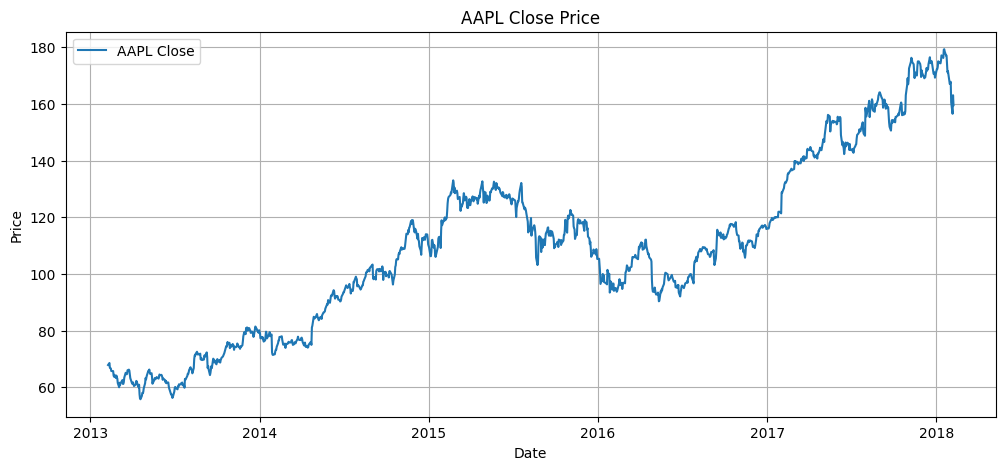

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(data['close'],label=f"{company} Close")
plt.title(f"{company} Close Price")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(); plt.grid(True)
plt.show()

In [ ]:
print(data['close'].describe())

count    1259.000000
mean      109.066698
std        30.556812
min        55.789900
25%        84.830650
50%       109.010000
75%       127.120000
max       179.260000
Name: close, dtype: float64


## 5. Decompose Time Series (Trend/Seasonality/Residual)

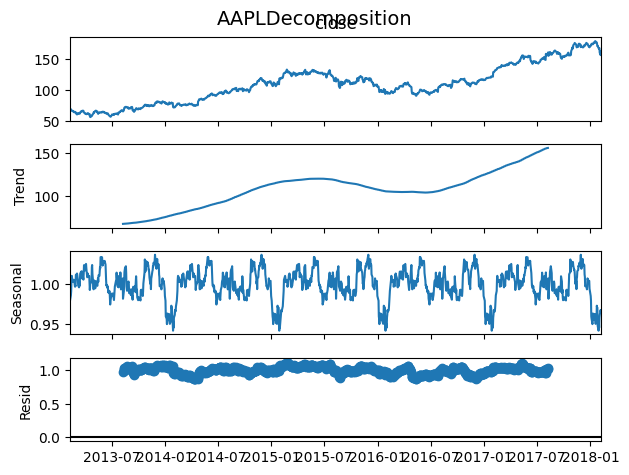

In [ ]:
# period - 252 trading days (approx 1 year) - adjust if needed

try:
    decomposition = seasonal_decompose(data['close'],model = 'multiplicative',period = 252)
    decomposition.plot();plt.suptitle(f"{company}Decomposition", fontsize = 14)
    plt.show()

except Exception as e:
    print("Decompose error:",e)

## 6. Train/Test Split

In [ ]:
train_frac = 0.8
train_size = int(len(data)* train_frac)
train = data.iloc[:train_size]
test = data.iloc[train_size:]
print("Train:", train.shape, "Test:",test.shape)

Train: (1007, 1) Test: (252, 1)


## 7. ARIMA Forecasting

In [ ]:
arima_order = (5,1,0)
arima_model = ARIMA(train['close'],order = arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps = len(test))

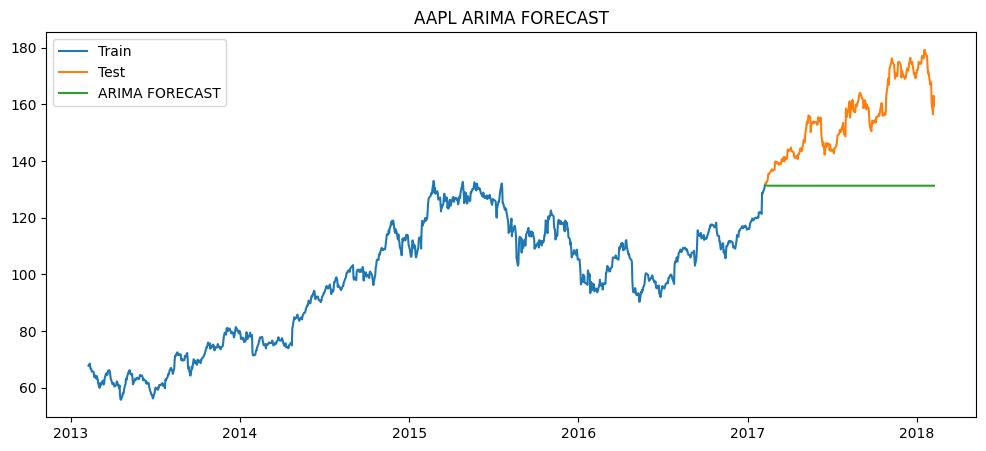

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train['close'], label = 'Train')
plt.plot(test['close'], label = 'Test')
plt.plot(test.index, arima_forecast, label = 'ARIMA FORECAST')
plt.legend(); plt.title (f"{company} ARIMA FORECAST")
plt.show()

In [ ]:
arima_mae = mean_absolute_error(test['close'],arima_forecast)
arima_rmse = np.sqrt(mean_absolute_error(test['close'],arima_forecast))
print("ARIMA MAE :", arima_mae, "RMSE:", arima_rmse)

ARIMA MAE : 24.32048340747452 RMSE: 4.9315802140363205


## 8. SARIMA Forecasting

In [ ]:
sarima_order = (2,1,2)
seasonal_order = (1,1,1,12) # adjust s if smaller dataset or different seasonality
sarima_model = SARIMAX(train['close'],order = sarima_order, seasonal_order = seasonal_order,enforce_stationarity=False,
enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps = len(test))

In [ ]:
print(sarima_forecast.shape)
print(sarima_forecast.head())

(252,)
1007    131.607401
1008    131.649307
1009    131.762420
1010    131.662389
1011    131.757813
Name: predicted_mean, dtype: float64


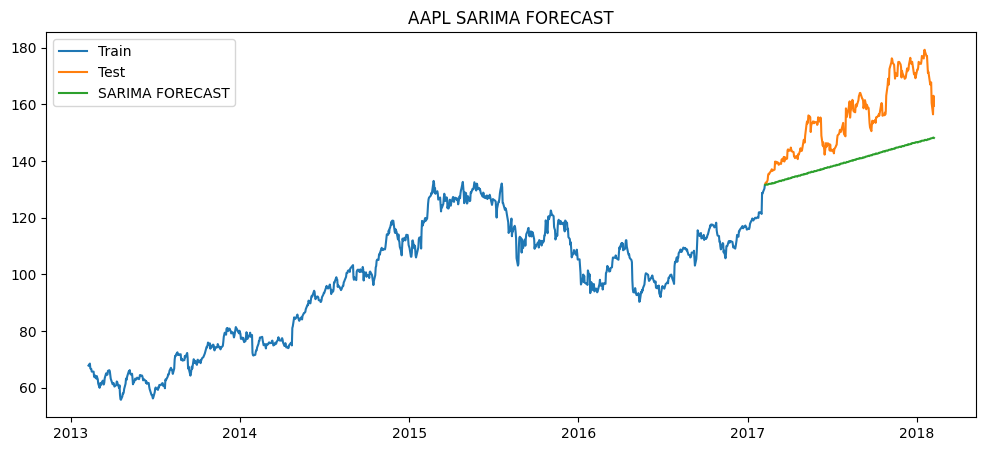

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train['close'], label = 'Train')
plt.plot(test['close'], label = 'Test')
plt.plot(test.index, sarima_forecast, label = 'SARIMA FORECAST')
plt.legend(); plt.title (f"{company} SARIMA FORECAST")
plt.show()


In [ ]:
sarima_mae = mean_absolute_error(test['close'],sarima_forecast)
sarima_rmse = np.sqrt(mean_absolute_error(test['close'],sarima_forecast))
print("SARIMA MAE :", sarima_mae, "RMSE:", sarima_rmse)

SARIMA MAE : 15.749077146482806 RMSE: 3.9685106962792487


## 9.PROPHET Forecasting

In [ ]:
#Install & Import Prophet
!pip install prophet
from prophet import Prophet

In [ ]:
df_prophet = df[df['Name'] == 'AAPL'].copy()
df_prophet = df_prophet.rename(columns={'date': 'ds', 'close': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
print("Prepared Data for Prophet:")
print(df_prophet.head())
print("\nData Info:")
df_prophet.info()

Prepared Data for Prophet:
             ds     open     high      low        y     volume  Name
1259 2013-02-08  67.7142  68.4014  66.8928  67.8542  158168416  AAPL
1260 2013-02-11  68.0714  69.2771  67.6071  68.5614  129029425  AAPL
1261 2013-02-12  68.5014  68.9114  66.8205  66.8428  151829363  AAPL
1262 2013-02-13  66.7442  67.6628  66.1742  66.7156  118721995  AAPL
1263 2013-02-14  66.3599  67.3771  66.2885  66.6556   88809154  AAPL

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 1259 to 2517
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   y       1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Name    1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1)

In [ ]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
m.fit(df_prophet)
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)
print("\nForecast Results (Last 5 days):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

DEBUG:cmdstanpy:input tempfile: /tmp/tmpu_wmvqzb/tcx5ztgw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu_wmvqzb/_1v7adym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7741', 'data', 'file=/tmp/tmpu_wmvqzb/tcx5ztgw.json', 'init=/tmp/tmpu_wmvqzb/_1v7adym.json', 'output', 'file=/tmp/tmpu_wmvqzb/prophet_model7jom9j1_/prophet_model-20250901065527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:55:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:55:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Forecast Results (Last 5 days):
             ds        yhat  yhat_lower  yhat_upper
1344 2018-05-04  190.323435  184.125463  196.376517
1345 2018-05-05  193.942359  187.756684  200.008225
1346 2018-05-06  194.135825  187.930006  200.492587
1347 2018-05-07  191.032494  184.410198  197.764389
1348 2018-05-08  191.253275  185.222025  197.554366


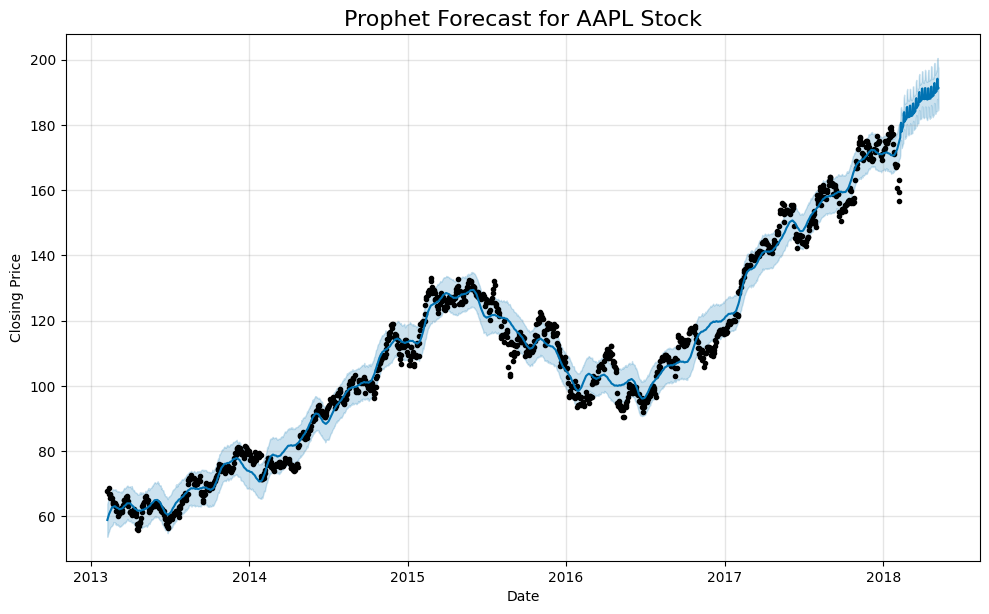

In [ ]:
# Plot the main forecast
fig1 = m.plot(forecast)
plt.title("Prophet Forecast for AAPL Stock", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

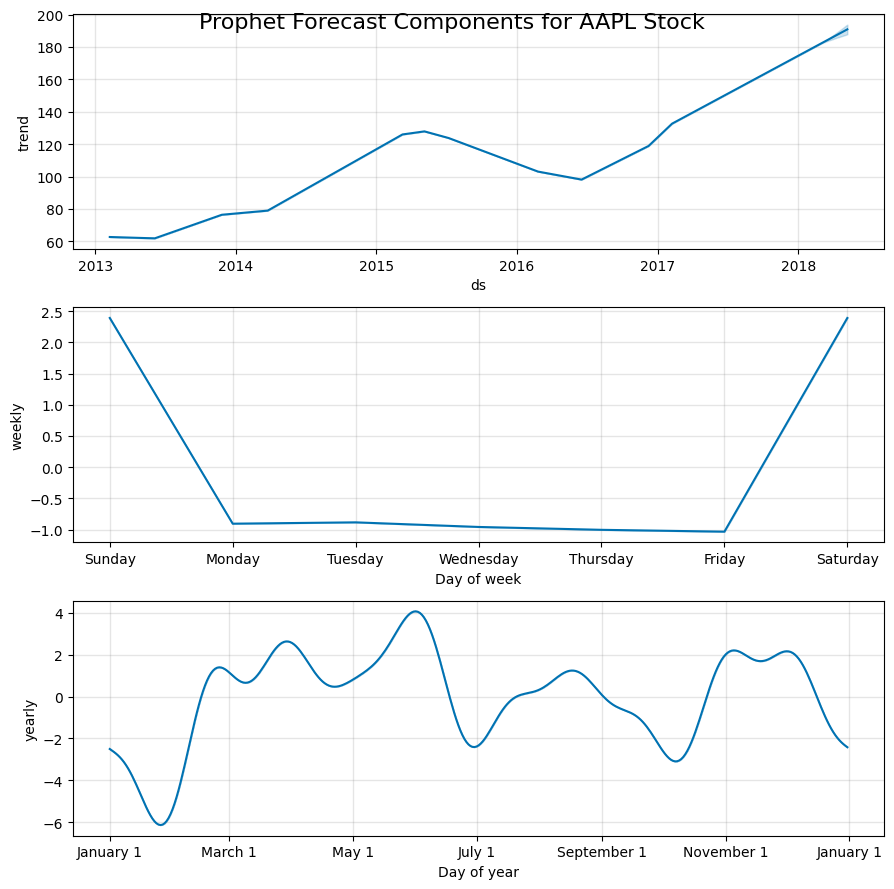

In [ ]:
# Plot the forecast components
fig2 = m.plot_components(forecast)
plt.suptitle("Prophet Forecast Components for AAPL Stock", fontsize=16)
plt.show()

In [ ]:
# Merge actual and forecast on date
df_merged = df_prophet.merge(forecast[['ds', 'yhat']], on='ds')

# Calculate MAE
mae = mean_absolute_error(df_merged['y'], df_merged['yhat'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df_merged['y'], df_merged['yhat']))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 3.2403679776572147
Root Mean Squared Error (RMSE): 4.076076665249159


In [ ]:
data.head()

,close
date,
2013-02-08,67.8542
2013-02-11,68.5614
2013-02-12,66.8428
2013-02-13,66.7156
2013-02-14,66.6556


In [ ]:
data.shape

(1259, 1)

In [ ]:
data.isnull().sum()

,0
close,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['close']])

print(scaled_data)

[[0.0977103 ]
 [0.103438  ]
 [0.08951884]
 ...
 [0.81558288]
 [0.86855117]
 [0.84028522]]


In [ ]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print("train data size:",train_data.size)
print("test data size:",test_data.size)

train data size: 1007
test data size: 252


In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] #i=0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_test.shape),print(y_test.shape)

(151, 100)
(151,)


(None, None)

In [ ]:
# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 379ms/step - loss: 0.0631 - val_loss: 0.1143
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - loss: 0.0071 - val_loss: 0.0364
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 0.0028 - val_loss: 0.0090
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0011 - val_loss: 0.0067
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - loss: 0.0012 - val_loss: 0.0075
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
import math
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_train,train_predict))

101.20461598953311

In [ ]:
math.sqrt(mean_squared_error(y_test,test_predict))

158.14825962484755

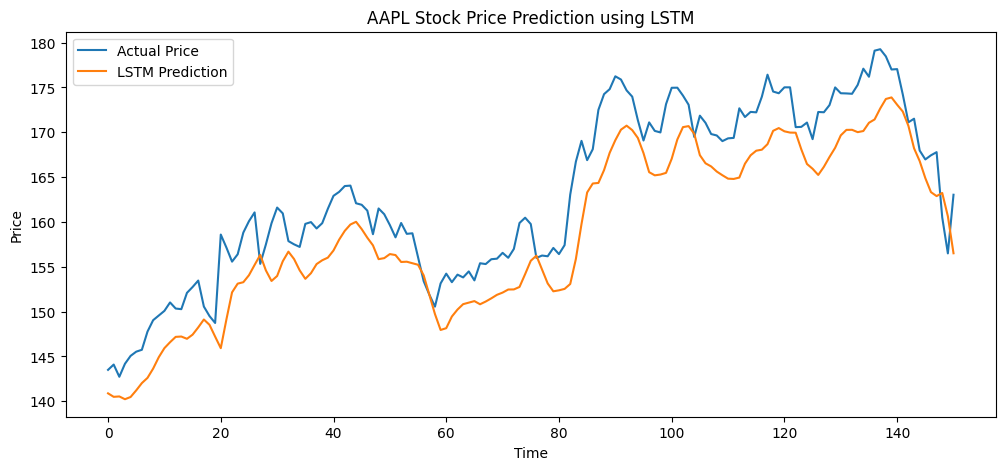

In [ ]:
# Inverse transform actual values
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(test_predict, label='LSTM Prediction')
plt.title('AAPL Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

mae = mean_absolute_error(y_test_inv, test_predict)
rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 4.378522177184654
RMSE: 4.866570641883612


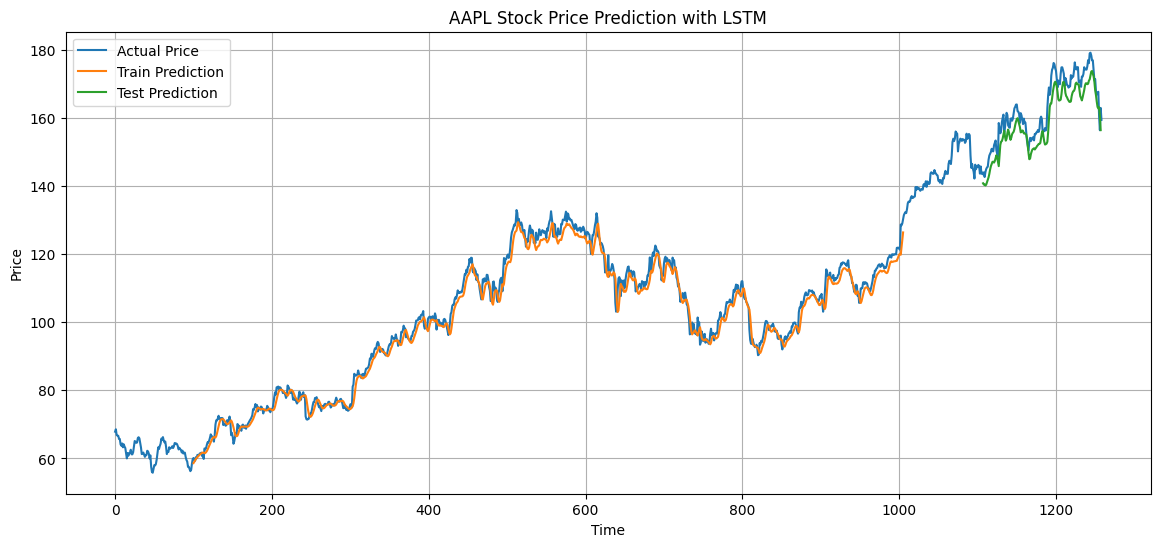

In [ ]:
# Create empty arrays for plotting full timeline
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(scaled_data)-1, :] = test_predict

# Inverse transform actual full dataset
actual_full = scaler.inverse_transform(scaled_data)

# Plot
plt.figure(figsize=(14,6))
plt.plot(actual_full, label="Actual Price")
plt.plot(trainPredictPlot, label="Train Prediction")
plt.plot(testPredictPlot, label="Test Prediction")
plt.title("AAPL Stock Price Prediction with LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()



📊 Model Comparison Table:
     Model         MSE        MAE       RMSE
0    ARIMA  742.477503  24.320483  27.248440
1   SARIMA  313.605175  15.749077  17.708901
2  Prophet   16.614401   4.378522   4.076077
3     LSTM   23.683510   4.378522   4.866571


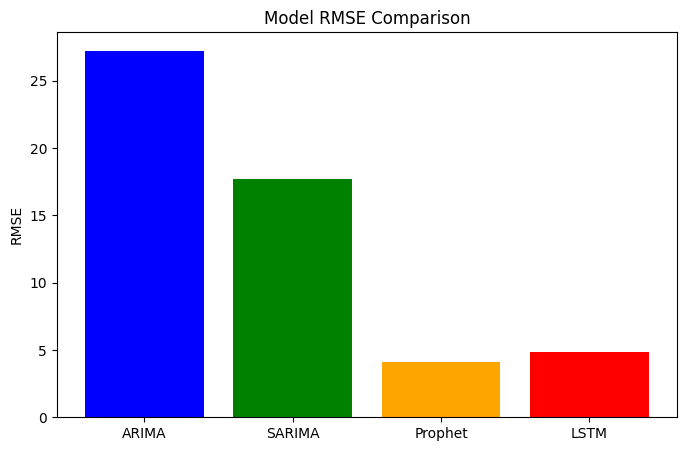

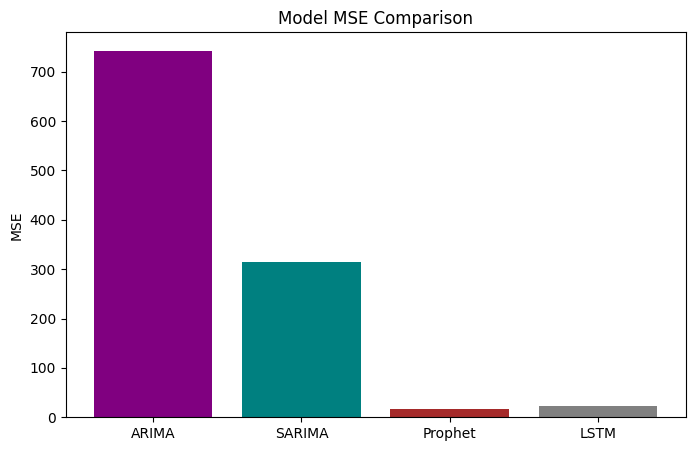

In [ ]:
# ------------------------------
# Step 6: Model Comparison & Summary Table (MSE, MAE, RMSE)
# ------------------------------

import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

results = []

# ARIMA
arima_mse = mean_squared_error(test['close'], arima_forecast)
results.append({
    "Model": "ARIMA",
    "MSE": arima_mse,
    "MAE": arima_mae,
    "RMSE": np.sqrt(arima_mse)
})

# SARIMA
sarima_mse = mean_squared_error(test['close'], sarima_forecast)
results.append({
    "Model": "SARIMA",
    "MSE": sarima_mse,
    "MAE": sarima_mae,
    "RMSE": np.sqrt(sarima_mse)
})

# Prophet
prophet_mse = mean_squared_error(df_merged['y'], df_merged['yhat'])
results.append({
    "Model": "Prophet",
    "MSE": prophet_mse,
    "MAE": mae,   # Prophet MAE you already calculated
    "RMSE": np.sqrt(prophet_mse)
})

# LSTM
lstm_mse = mean_squared_error(y_test_inv, test_predict)
results.append({
    "Model": "LSTM",
    "MSE": lstm_mse,
    "MAE": mae,   # LSTM MAE you already calculated
    "RMSE": np.sqrt(lstm_mse)
})

# Convert to DataFrame
results_df = pd.DataFrame(results)
print("\n📊 Model Comparison Table:")
print(results_df)

# ------------------------------
# Plot RMSE Comparison
# ------------------------------
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['RMSE'], color=['blue','green','orange','red'])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

# ------------------------------
# Plot MSE Comparison
# ------------------------------
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['MSE'], color=['purple','teal','brown','grey'])
plt.title("Model MSE Comparison")
plt.ylabel("MSE")
plt.show()


In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.8 MB/s eta 0:00:00


2025-09-01 07:01:16.289 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-01 07:01:16.291 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-01 07:01:16.292 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-01 07:01:16.463 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-01 07:01:16.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-01 07:01:16.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-01 07:01:16.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-01 07:01:16.970 Thread 'Thread-5': missing 

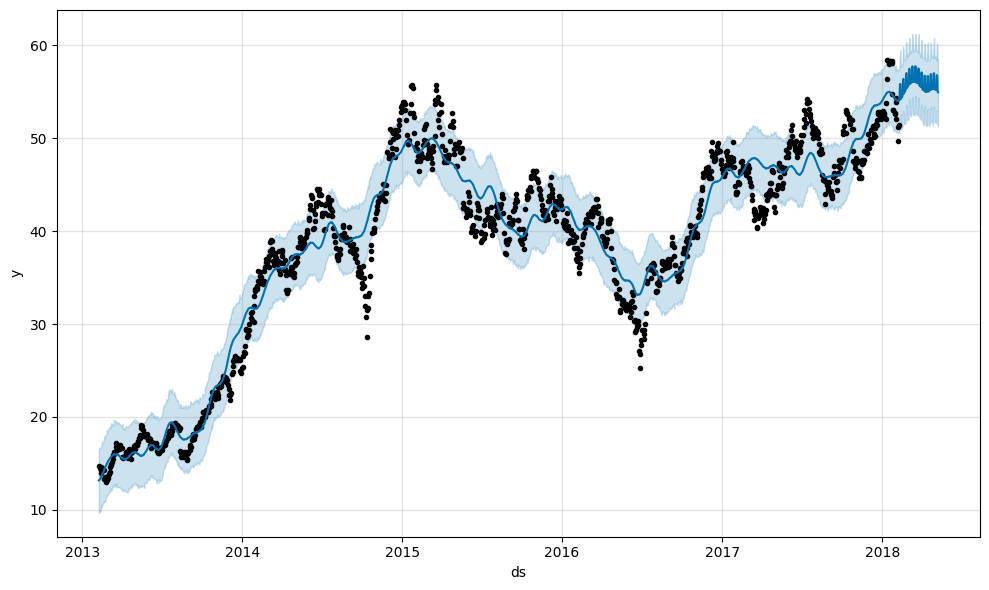

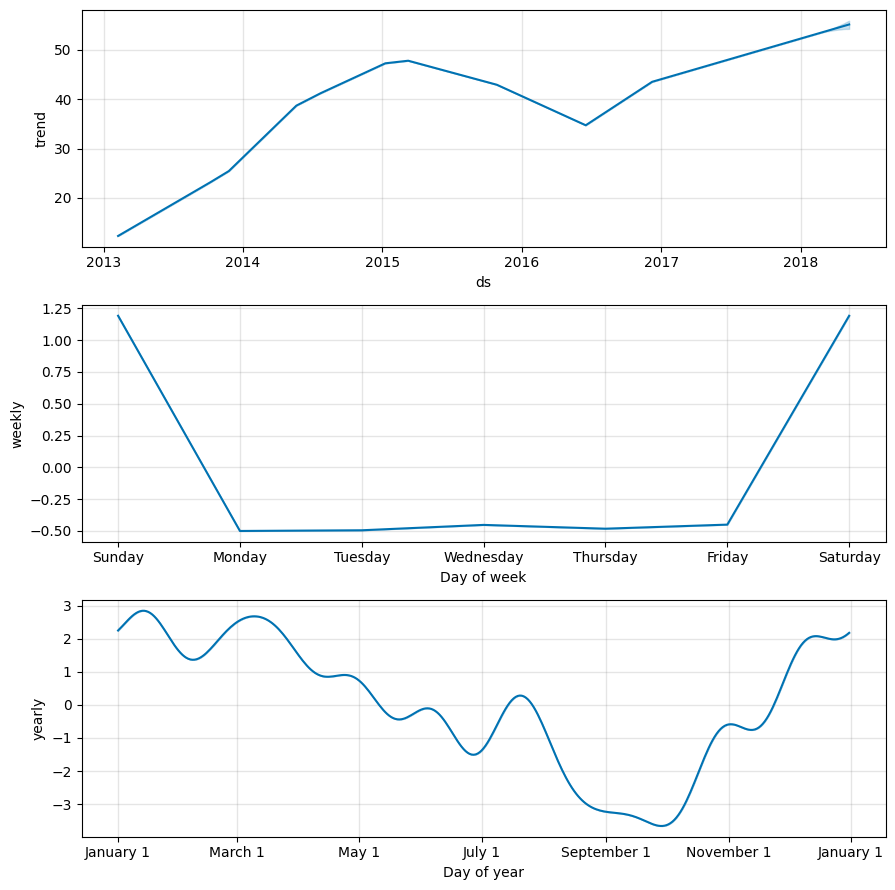

In [ ]:
# ------------------------------
# Stock Forecasting Dashboard (Streamlit)
# ------------------------------
# Save this as app.py and run: streamlit run app.py
# ------------------------------

import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ------------------------------
# Load Data
# ------------------------------
@st.cache_data
def load_data():
    df = pd.read_csv("all_stocks_5yr.csv")
    df['date'] = pd.to_datetime(df['date'])
    return df

df = load_data()

st.title("📈 Stock Market Forecasting Dashboard")
st.write("Compare actual prices with forecasts using **Prophet** (and extend to LSTM/ARIMA if needed).")

# ------------------------------
# Sidebar - Stock Selection
# ------------------------------
companies = df['Name'].unique()
company = st.sidebar.selectbox("Select a Stock", companies)

periods = st.sidebar.slider("Days to Forecast", 30, 365, 90)

# ------------------------------
# Prepare Data
# ------------------------------
data = df[df['Name'] == company].copy()
data = data.rename(columns={'date': 'ds', 'close': 'y'})

# ------------------------------
# Prophet Model
# ------------------------------
m = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True)
m.fit(data)

future = m.make_future_dataframe(periods=periods)
forecast = m.predict(future)

# ------------------------------
# Plot Historical & Forecast
# ------------------------------
st.subheader(f"📊 {company} Stock Price & Forecast ({periods} days)")
fig1 = m.plot(forecast)
st.pyplot(fig1)

# Components (trend, weekly, yearly)
st.subheader("🔎 Forecast Components")
fig2 = m.plot_components(forecast)
st.pyplot(fig2)

# ------------------------------
# Error Metrics (on historical data only)
# ------------------------------
df_merged = data.merge(forecast[['ds','yhat']], on='ds', how='left')
mae = mean_absolute_error(df_merged['y'], df_merged['yhat'])
mse = mean_squared_error(df_merged['y'], df_merged['yhat'])
rmse = np.sqrt(mse)

st.subheader("📉 Model Performance (Prophet)")
st.write(f"**MAE:** {mae:.2f}")
st.write(f"**MSE:** {mse:.2f}")
st.write(f"**RMSE:** {rmse:.2f}")
